In [3]:
%matplotlib inline

import sklearn as sk
import nilearn as nl 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

/home/pbellec/anaconda3/envs/brainsprite/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Simulate time series
We are going to simulate time series with a cluster structure. Let's assume we have 100 time points, 300 brain regions and 3 clusters. The alpha parameter will control for the strength of the clustering.

In [4]:
nb_time = 100    # # of time samples
nb_roi = 300     # # of regions
nb_cluster = 5   # # of clusters 
alpha = 2      # this parameter controls the "strength" of the clustering.

In [5]:
y = np.random.normal(size=[nb_roi , nb_time])
ind = np.linspace(0,nb_roi,nb_cluster+1,dtype="int")
for cc in range(0, nb_cluster) :
    cluster = range(ind[cc],ind[cc+1])
    sig = np.random.normal(size=[1,nb_time])
    y[cluster,:] = y[cluster,:] + alpha * np.repeat(sig,ind[cc+1]-ind[cc],0)

In [6]:
nb_cluster = 10   # # of subclusters
ind = np.linspace(0,nb_roi,nb_cluster+1,dtype="int")
for cc in range(0, nb_cluster) :
    cluster = range(ind[cc],ind[cc+1])
    sig = np.random.normal(size=[1,nb_time])
    y[cluster,:] = y[cluster,:] + alpha * np.repeat(sig,ind[cc+1]-ind[cc],0)

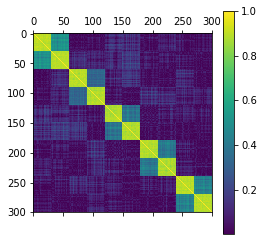

In [7]:
R = sp.corrcoef(y)
plt.matshow(np.abs(R))
plt.colorbar()

# Spectral analysis of the adjacency matrix

For the sake of argument, we generate an adjacency matrix by thresholding the correlation matrix at an arbitrary threshold. We could also threshold it based on sparsity, or use the correlation matrix directly. A normalization is applied on the adjacency matrix to control the size of the eigenvalues. 

We then apply the `eigh` method, which is a very fast eigen decomposition method for hermitian (symmetric) matrices. It returns two outputs:
  * `Lambda` is the vector of eigen values, in increasing order.
  * `U` is an array where the i-th column stores the i-th eigen vector. 

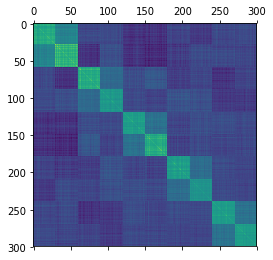

In [9]:
W = R;
D = np.diag(np.sum(W,axis=1))
N = np.diag(np.power(np.sum(W,axis=1),-1/2))
W = np.matmul(np.matmul(N,W),N)
plt.matshow(W)
Lambda , U = np.linalg.eigh(W)

Let's plot the eigen values. 

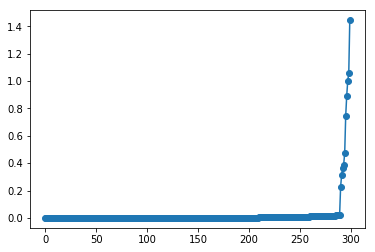

In [10]:
plt.plot(Lambda,'-o')

They are indeed increasing, but not non-negative, as one would expect for a symmetric matrix. May be due to some kind of numerical error, see this [stackoverflow](https://stackoverflow.com/questions/36819739/scipy-eigh-gives-negative-eigenvalues-for-positive-semidefinite-matrix) post. The max eigenvalue is now 1, probably thanks to the normalization (needs to be checked).

Now let's chek the largest eigen vectors.

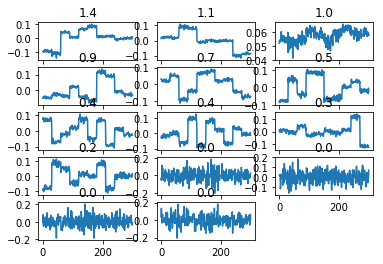

In [11]:
for pp in range(1,15):
    plt.subplot(5,3,pp)
    plt.plot(U[:,-pp])
    plt.title("%1.1f" % Lambda[-pp])

The first five eigen vectors are (noisy) linear combination of the indicator functions corresponding to each cluster. We can also notice a very large drop-off between the fifth and sixth eigen values, consistent with the presence of five clusters. As a side note: this shows how easy it is to detect the number of clusters, when there is indeed a single and clear clustering structure in the data. 

We can have a look at the Euclidean producs between eigen vectors.

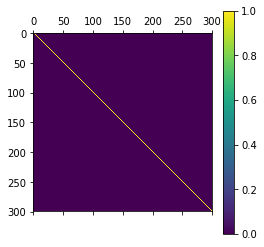

In [12]:
C = np.matmul(np.transpose(U),U)
plt.matshow(np.abs(C))
plt.colorbar()

In [13]:
C[0:8,0:8]

array([[ 1.00000000e+00,  1.43982049e-16,  8.32667268e-17,
         4.85722573e-17,  3.46944695e-18, -2.35922393e-16,
         3.29597460e-17, -6.93889390e-17],
       [ 1.43982049e-16,  1.00000000e+00,  2.15105711e-16,
        -3.81639165e-17, -1.73472348e-18,  1.57209315e-16,
         2.77555756e-17,  7.97972799e-17],
       [ 8.32667268e-17,  2.15105711e-16,  1.00000000e+00,
        -3.46944695e-18, -5.89805982e-17, -5.89805982e-17,
        -8.32667268e-17, -2.60208521e-17],
       [ 4.85722573e-17, -3.81639165e-17, -3.46944695e-18,
         1.00000000e+00,  4.33680869e-16, -1.11022302e-16,
         7.63278329e-17, -3.46944695e-17],
       [ 3.46944695e-18, -1.73472348e-18, -5.89805982e-17,
         4.33680869e-16,  1.00000000e+00, -5.89805982e-17,
         6.93889390e-18,  0.00000000e+00],
       [-2.35922393e-16,  1.57209315e-16, -5.89805982e-17,
        -1.11022302e-16, -5.89805982e-17,  1.00000000e+00,
        -1.24032729e-16,  1.38777878e-17],
       [ 3.29597460e-17,  2.775557

As expected, this is the identity matrix. This means that the eigen vectors have an Euclidean norm of one, and are all orthogonal to each others.

# Spectral analysis of the Graph Laplacian

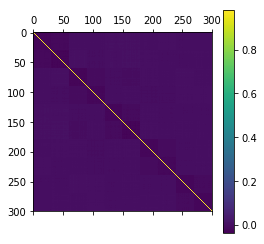

In [14]:
W = R;
D = np.diag(np.sum(W,axis=1))
N = np.diag(np.power(np.sum(W,axis=1),-1/2))
L = np.matmul(np.matmul(N,D-W),N)
plt.matshow(L)
plt.colorbar()

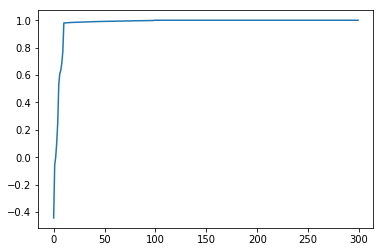

In [15]:
Lambda , U = np.linalg.eigh(L)
plt.plot(Lambda)

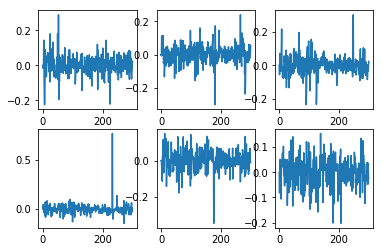

In [16]:
for pp in range(1,7):
    plt.subplot(2,3,pp)
    plt.plot(U[:,-pp])

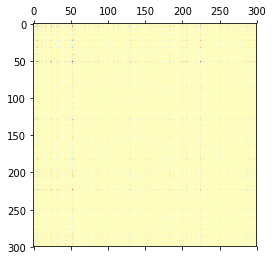

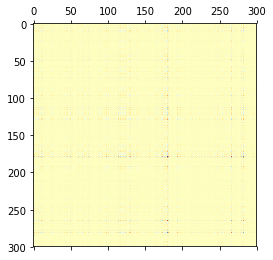

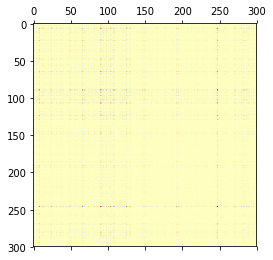

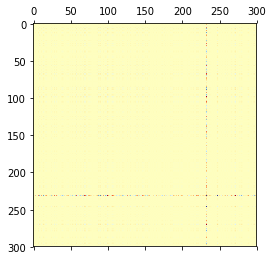

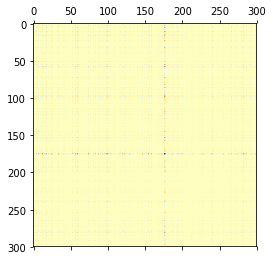

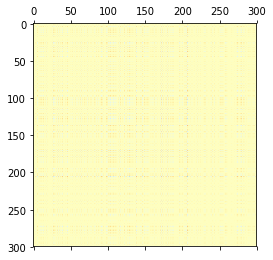

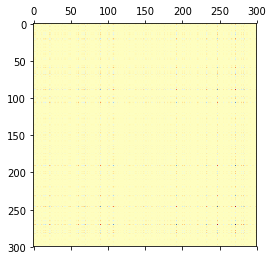

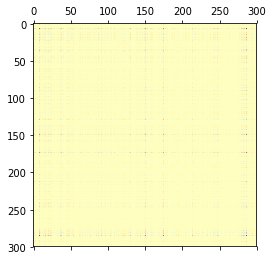

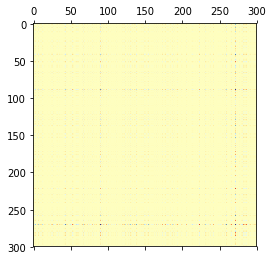

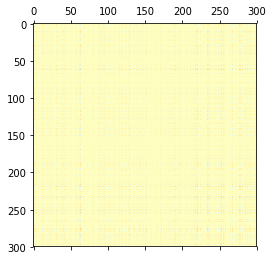

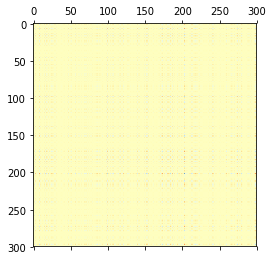

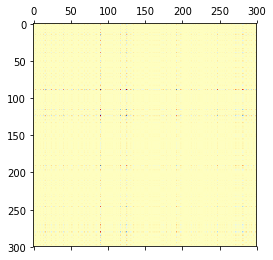

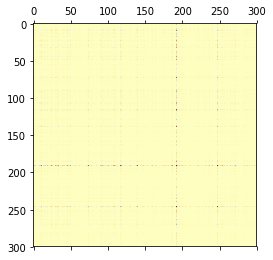

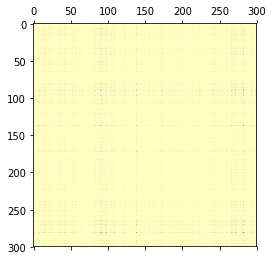

In [17]:
for pp in range(1,15):
    a = U[:,-pp]
    a.shape = (a.size , 1)
    M = a.dot(a.transpose())
    plt.matshow(M,cmap="RdYlBu",vmin=-0.1,vmax=0.1)

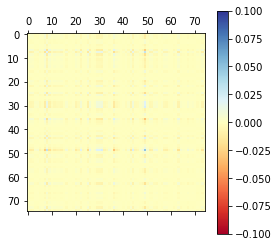

In [18]:
a = U[:,-1]
a.shape = (a.size , 1)
M = a.dot(a.transpose())
plt.matshow(M[175:250,175:250],cmap="RdYlBu",vmin=-0.1,vmax=0.1)
plt.colorbar()